In [8]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

MAX_SEQUENCE_LENGTH = 128
LEARNING_RATE = 1e-5
BATCH_SIZE = 32
NUM_EPOCHS = 3  



In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
    # Using the tokenizer from the DistilBert model from HuggingFace
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )


In [4]:

# Load dataset
df = pd.read_csv('../toy_model/media_bias.csv')

# Clean dataset
df = df[df.Label_bias != 'No agreement']
df = df[df.article != 'NaN']
df = df[df.sentence != 'NaN']

# Replace label with 0, 1
df['Label_bias'] = df['Label_bias'].replace('Biased', 1)
df['Label_bias'] = df['Label_bias'].replace('Non-biased', 0)

df = df.rename(columns={'sentence': 'text', 'Label_bias': 'label'})

train_data, validation_data, train_label, validation_label = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=.15,
    shuffle=True
)

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(train_data)),  # Convert BatchEncoding instance to dictionary
    train_label
)).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
validation_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(validation_data)),
    validation_label
)).batch(BATCH_SIZE).prefetch(1)

In [7]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)
# add learning layers to model

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

AttributeError: 'DistilBertForSequenceClassification' object has no attribute 'compile'

In [ ]:

model.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

In [7]:
# test model and plot confusion matrix
model.evaluate(validation_dataset)

15/15 [==============================] - 81s 5s/step - loss: 0.7294


0.7293604016304016

In [12]:
#Get predictions
predictions = model.predict(validation_dataset)
predictions = tf.nn.softmax(predictions[0], axis=1)
predictions = tf.argmax(predictions, axis=1)



tf.Tensor(
[1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0
 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0
 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0
 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0
 1 0 0 1 1 0 0 0 1 1 1], shape=(233,), dtype=int64)


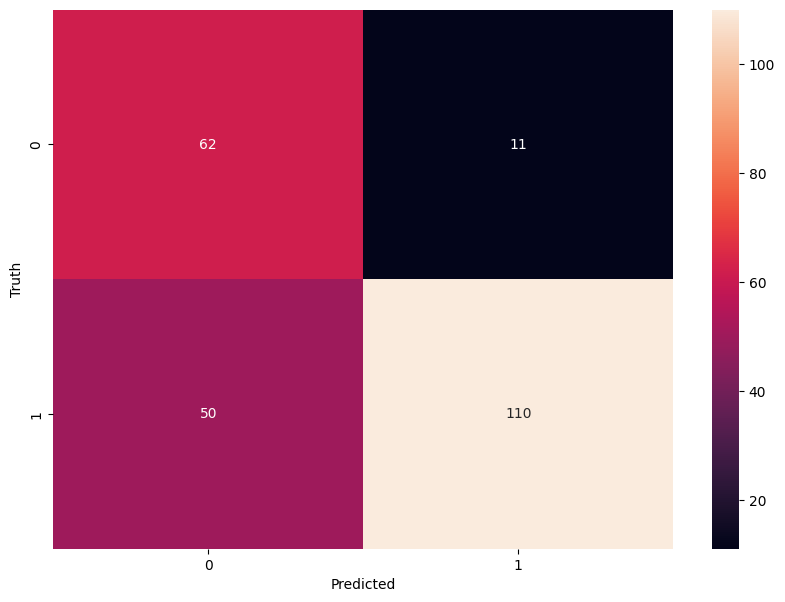

In [15]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

plot_confusion_matrix(validation_label, predictions)



In [24]:
# show accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(validation_label, predictions))


0.7381974248927039


In [81]:
inputs = dict(tokenizer(["This is a factual sentence that can be seen in a good light don't you think so, but it seems like they're all unbiased.","YouTube is making clear there will be no “birtherism” on its platform during this year’s U.S. presidential election – a belated response to a type of conspiracy theory more prevalent in the 2012 race.", "The increasingly bitter dispute between American women’s national soccer team and the U.S. Soccer Federation spilled onto the field Wednesday night when players wore their warm-up jerseys inside outin a protest before their 3-1 victory over Japan.","A professor who teaches climate change classes — a subject some would question as a legitimate area of study — said she has seen students who suffer fear, grief, stress, and anxiety about the future."], padding=True, truncation=True, return_tensors="tf"))

In [90]:
print(inputs)

{'input_ids': <tf.Tensor: shape=(4, 50), dtype=int32, numpy=
array([[  101,  2023,  2003,  1037, 25854,  6251,  2008,  2064,  2022,
         2464,  1999,  1037,  2204,  2422,  2123,  1005,  1056,  2017,
         2228,  2061,  1010,  2021,  2009,  3849,  2066,  2027,  1005,
         2128,  2035,  4895, 11607,  6924,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [  101,  7858,  2003,  2437,  3154,  2045,  2097,  2022,  2053,
         1523,  4182, 11124,  6491,  1524,  2006,  2049,  4132,  2076,
         2023,  2095,  1521,  1055,  1057,  1012,  1055,  1012,  4883,
         2602,  1516,  1037, 20252,  3064,  3433,  2000,  1037,  2828,
         1997,  9714,  3399,  2062, 15157,  1999,  1996,  2262,  2679,
         1012,   102,     0,     0,     0],
       [  101,  1996,  6233,  8618,  7593,  2090,  2137,  2308,  1521,
         1055,  2120,  4715,  2136,  1998,  1996,  1057,  1012,  1055,

In [83]:
newPrediction = model.predict(inputs)
print(newPrediction)
#get the highest probability and its index from the prediction
newPrediction = tf.nn.softmax(newPrediction[0], axis=1).numpy()
print(newPrediction)
label = tf.argmax(newPrediction, axis=1).numpy()
# print the index with the highest probability from tensor
print(label)



TFSequenceClassifierOutput(loss=None, logits=array([[-1.4891721,  1.2353058],
       [-2.3630428,  2.0507863],
       [ 2.066503 , -2.1085992],
       [ 2.0238175, -2.0706954]], dtype=float32), hidden_states=None, attentions=None)
[[0.06154434 0.93845564]
 [0.01196386 0.98803616]
 [0.98485917 0.01514085]
 [0.9836092  0.01639073]]
[1 1 0 0]


In [89]:
#Save the model to a local folder
model.save_pretrained('./model')

In [86]:
# Load the model from the local folder for testing purposes
modelOpen = TFDistilBertForSequenceClassification.from_pretrained("./model")

Some layers from the model checkpoint at ./model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_79']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./model and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
#Testing if the loaded model works
newPrediction = modelOpen.predict(inputs)
newPrediction = tf.nn.softmax(newPrediction[0], axis=1).numpy()
print(newPrediction)
label = tf.argmax(newPrediction, axis=1).numpy()
print(label)

TFSequenceClassifierOutput(loss=None, logits=array([[-1.4891721,  1.2353058],
       [-2.3630428,  2.0507863],
       [ 2.066503 , -2.1085992],
       [ 2.0238175, -2.0706954]], dtype=float32), hidden_states=None, attentions=None)
[[0.06154434 0.93845564]
 [0.01196386 0.98803616]
 [0.98485917 0.01514085]
 [0.9836092  0.01639073]]
[1 1 0 0]


In [91]:
model.save('./modelpb', save_format='tf')

INFO:tensorflow:Assets written to: ./modelpb\assets


INFO:tensorflow:Assets written to: ./modelpb\assets


In [114]:
# Load the model from the local folder for testing purposes
modelOpen = tf.keras.models.load_model('./bert_model_15-12-22')

import numpy as np
#Testing if the loaded model works
newPrediction = modelOpen.predict(inputs)
predictionArray = np.argmax(newPrediction, axis=1)
print(newPrediction)
print(predictionArray)


{'logits': array([[-1.4891721,  1.2353058],
       [-2.3630428,  2.0507863],
       [ 2.066503 , -2.1085992],
       [ 2.0238175, -2.0706954]], dtype=float32)}
0


In [124]:
from scipy.special import softmax
print(newPrediction)
confidence = softmax(newPrediction['logits'])
print(confidence)
predictionArray = np.argmax(newPrediction['logits'], axis=1)
print(predictionArray)

{'logits': array([[-1.4891721,  1.2353058],
       [-2.3630428,  2.0507863],
       [ 2.066503 , -2.1085992],
       [ 2.0238175, -2.0706954]], dtype=float32)}
[[0.00827894 0.12624098]
 [0.00345507 0.28533763]
 [0.28985763 0.00445616]
 [0.27774528 0.00462831]]
[1 1 0 0]
